<a href="https://colab.research.google.com/github/GonMazzini/Loads_Surrogate_Transferability/blob/main/PyTorch_Model_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Try outputs e inputs with different scaler?
- Add one more layer?
- Add cuda to run in collab

In [ ]:
import pandas as pd 
import numpy as np
import math
from random import shuffle

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [ ]:
from tqdm import tqdm

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("GPU")
else:
    device = torch.device("cpu")
    print("CPU")

GPU


# 0- Read the data as a data frame

In [ ]:
df = pd.read_excel('LoadsDataBase_6D_Set123_FiltMinMaxCrit.xlsx') # Average the values from Set1,Set2 and Set3.
df.head(2)
# 0 : TT_Mx_avg
# 1 : TT_My_avg
# 2 : TB_Mx_avg
# 3 : TB_My_avg
# 4 : MS_Mz_avg
# 5 : BR_Mx_avg
# 6 : BR_My_avg
# 7 : TT-Mz_avg

,Unnamed: 0,pointno,U,SigmaU,Alpha,MannL,MannGamma,VeerDeltaPhi,TT_Mx_avg,TT_My_avg,TB_Mx_avg,TB_My_avg,TT_Mz_avg,MS_Mz_avg,BR_Mx_avg,BR_My_avg
0,0,1,4.000000,0.100000,-0.650000,7.500000,1.000000,-22.250000,747.561872,200.666288,6708.717789,8861.885588,819.209904,63.457528,4253.317748,15006.726860
1,1,2,10.150758,1.208656,-0.139692,48.470634,1.363636,-4.771217,3556.031457,676.339081,16692.647572,6329.099515,3746.460605,1354.995442,10409.290476,16289.414152


# ============================================================
# ==========================Section 1 ==========================
# ============================================================

In [ ]:
X = df.iloc[:,2:8]
y = df.iloc[:,8:]

In [ ]:
# Test split:
X, X_test, y, y_test = train_test_split(X,y, test_size = 0.2, shuffle = True,  random_state = 101)

print(f'The filtered data set consits on: {len(df)} entries.')
print(f'A total of {len(X)} will be used for training and validation.')
print(f'A total of {len(X_test)} will be used for testing the final model.')


The filtered data set consits on: 7664 entries.
A total of 6131 will be used for training and validation.
A total of 1533 will be used for testing the final model.


### From now on, "X" and "y" will be used for train-validate the model. 

In [ ]:
feature_range = (0, 1)
scaler_x = preprocessing.MinMaxScaler(feature_range=feature_range).fit(X)
X_scaled = scaler_x.transform(X)

### Separte between train and validation

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_scaled,y.values, test_size = 0.3, shuffle = True,  random_state = 101)

### The PyTorch worfklow can be summarized as follows:
- 1) Design model (input, output size, forward pass)
- 2) Construct loss and optimizer
- 3) Training loop
   - forward pass: compute prediction based on the current weights and biases of the net
   - backward pass: compute the gradients of the loss function wrt. to model parameters
   - update weigths in

In [ ]:
input_size = 6             # np.shape(X_train)[1]
output_channels = 8        # np.shape(y_train)[1]
num_hid_1 = 50
num_hid_2 = 50

In [ ]:
class Net(nn.Module):
    
    def __init__(self, num_hid_1, num_hid_2):   
        super(Net,self).__init__()  # inherit from the superclass Module
        self.num_hid_1 = num_hid_1
        self.num_hid_2 = num_hid_2
        
        self.fc1 = nn.Linear(in_features= input_size,
                             out_features= self.num_hid_1,                             
                            bias = True)  
        
        self.fc2 = nn.Linear(in_features = self.num_hid_1, 
                             out_features = self.num_hid_2,
                            bias = True)
        
        self.fc3 = nn.Linear(in_features = self.num_hid_2, 
                             out_features = output_channels,
                            bias = True)
        
#        self.dropout = nn.Dropout(p=0.15)
        
    def forward(self,x):
        
        out = self.fc1(x)  
#        out = self.dropout(out)
        out = F.relu(out)
        out = self.fc2(out)
#        out = self.dropout(out)
        out = F.relu(out)
        out = self.fc3(out)                       #  torch.tanh(self.fc3(out))
        
        return out  

In [ ]:
# instantiate the class
model = Net(num_hid_1,num_hid_2)

if torch.cuda.is_available():
  model.to(device)

# Define the loss function (mean square error)
loss = nn.MSELoss()

# Instantiate optimizer passing the net parameters as argument, and learning rate
optimizer = optim.Adam(model.parameters(), lr = 0.01)

# list to store results
train_losses , val_losses= [],[]



In [ ]:
# Try a dummy forward
model(torch.tensor(X_train[0]).float().to(device))  # beware that need to convert from double to float

tensor([-0.0750, -0.0831,  0.2280,  0.0926,  0.1009, -0.1329, -0.0028, -0.1012],
       device='cuda:0', grad_fn=<AddBackward0>)

# 2.1- Use the PyTorch DataLoader and Dataset utils.
- DataLoader class combines a dataset and a sampler, and provides an iterable over the given dataset for training the model
- Dataset: just an abstract class representing a :class:`Dataset`

In [ ]:
class FatigueLoads_TrainSet(Dataset):

    def __init__(self):
        self.n_samples = X_train.shape[0]
        self.x_data = torch.from_numpy(X_train) # size [n_samples, n_features]
        self.y_data = torch.from_numpy(y_train) # size [n_samples, 1]

    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples
    
class FatigueLoads_ValidationSet(Dataset):

    def __init__(self):
        self.n_samples = X_val.shape[0]
        self.x_data = torch.from_numpy(X_val) # size [n_samples, n_features]
        self.y_data = torch.from_numpy(y_val) # size [n_samples, 1]

    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples

### Get first sample and unpack. Note that the enviromental inputs are normalized using MinMaxScaler

In [ ]:
X_train

array([[0.34582638, 0.39975255, 0.30220954, 0.36713682, 0.48301552,
        0.28241656],
       [0.4095821 , 0.43835602, 0.45210266, 0.7277867 , 0.001572  ,
        0.2359949 ],
       [0.15517834, 0.07085183, 0.51051779, 0.61239064, 0.64506869,
        0.47902875],
       ...,
       [0.31327694, 0.4362048 , 0.21987929, 0.61073982, 0.15658533,
        0.38261806],
       [0.16744948, 0.28249574, 0.01555323, 0.33624948, 0.53243114,
        0.16852014],
       [0.10781344, 0.199571  , 0.38533679, 0.4492055 , 0.52573303,
        0.28472862]])

### Get first sample and unpack. Note that the enviromental inputs are normalized using MinMaxScaler

In [ ]:
train_dataset = FatigueLoads_TrainSet()
valid_dataset = FatigueLoads_ValidationSet()

first_data = train_dataset[0]
features, loads = first_data
print(features, loads)

tensor([0.3458, 0.3998, 0.3022, 0.3671, 0.4830, 0.2824], dtype=torch.float64) tensor([ 4859.7039,   943.1698, 24910.7801,  8530.0205,  5068.9983,  2010.7064,
        15754.2171, 16978.6921], dtype=torch.float64)


In [ ]:
batch_size = 128
num_epochs = 1000

num_batches_train = X_train.shape[0] // batch_size
num_batches_test = X_val.shape[0] // batch_size

print(f'Num batches train: {num_batches_train}')
print(f'Num batches valid: {num_batches_test}')
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=0)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=0)

Num batches train: 33
Num batches valid: 14


# 3.1- Start training loop 

In [ ]:
for epoch in tqdm(range(num_epochs)):
    
    epoch_loss = 0
    model.train()
    
    for i, (inputs, loads) in enumerate(train_loader):
        #print(features, loads)
        
        optimizer.zero_grad()                      # zeroize accumulated gradients in parameters             
        
        output = model(inputs.float().to(device))             # forwards pass       
        batch_loss = loss(output, loads.float().to(device))   # compute loss for current batch
        
        batch_loss.backward()                      # compute the gradient of the loss wrt. model parameters
        optimizer.step()                           # update weights according to the comptued gradients
        
    
    epoch_loss_train = 0
    epoch_loss_test = 0
    model.eval()
    
    ##### Evaluate training
    for i, (inputs, loads) in enumerate(train_loader):
        
        output = model(inputs.float().to(device))
        
        batch_loss_train = loss(output, loads.float().to(device))  # compute loss for the current batch
        epoch_loss_train += batch_loss_train            # accumulate loss for the current epoch
        
        #print(f'Epoch: {epoch+1}/{num_epochs}  | Step {i+1}/{n_iterations}')
    
    ##### Evaluate validation    
    for i, (inputs, loads) in enumerate(valid_loader):
        
        output = model(inputs.float().to(device))
        
        batch_loss_test = loss(output, loads.float().to(device))  # compute loss for the current batch
        epoch_loss_test += batch_loss_test     # accumulate loss for the current epoch
        
        #print(f'Epoch: {epoch+1}/{num_epochs}  | Step {i+1}/{n_iterations}')
    
    if epoch % 10 == 0: 
        print(f'Epoch: {epoch+1}/{num_epochs} | Train loss: {epoch_loss_train/num_batches_train}       | Val loss {epoch_loss_test/num_batches_test}')
        
    # store in list for plotting the loss per epoch    
    val_losses.append(epoch_loss_test.cpu().detach().numpy()/num_batches_test)  
    train_losses.append(epoch_loss_train.cpu().detach().numpy()/num_batches_train)  

  0%|          | 1/1000 [00:00<02:59,  5.57it/s]

Epoch: 1/1000 | Train loss: 185321168.0       | Val loss 198015792.0


  1%|          | 12/1000 [00:02<03:02,  5.41it/s]

Epoch: 11/1000 | Train loss: 22813800.0       | Val loss 24076390.0


  2%|▏         | 22/1000 [00:04<02:57,  5.50it/s]

Epoch: 21/1000 | Train loss: 15123659.0       | Val loss 16066152.0


  3%|▎         | 32/1000 [00:06<02:54,  5.56it/s]

Epoch: 31/1000 | Train loss: 14391743.0       | Val loss 15019890.0


  4%|▍         | 42/1000 [00:07<02:52,  5.54it/s]

Epoch: 41/1000 | Train loss: 14263581.0       | Val loss 14828755.0


  5%|▌         | 52/1000 [00:09<02:49,  5.60it/s]

Epoch: 51/1000 | Train loss: 14103833.0       | Val loss 14795424.0


  6%|▌         | 62/1000 [00:11<02:46,  5.65it/s]

Epoch: 61/1000 | Train loss: 13906781.0       | Val loss 14477123.0


  7%|▋         | 72/1000 [00:13<02:44,  5.64it/s]

Epoch: 71/1000 | Train loss: 13712489.0       | Val loss 14063454.0


  8%|▊         | 82/1000 [00:15<02:42,  5.64it/s]

Epoch: 81/1000 | Train loss: 13339829.0       | Val loss 13861875.0


  9%|▉         | 92/1000 [00:16<02:40,  5.67it/s]

Epoch: 91/1000 | Train loss: 8452773.0       | Val loss 8943330.0


 10%|█         | 102/1000 [00:18<02:40,  5.60it/s]

Epoch: 101/1000 | Train loss: 6685475.0       | Val loss 7095224.5


 11%|█         | 112/1000 [00:20<02:36,  5.68it/s]

Epoch: 111/1000 | Train loss: 5390415.0       | Val loss 5661768.5


 12%|█▏        | 122/1000 [00:22<02:40,  5.47it/s]

Epoch: 121/1000 | Train loss: 5006729.5       | Val loss 5200845.5


 13%|█▎        | 132/1000 [00:23<02:31,  5.71it/s]

Epoch: 131/1000 | Train loss: 4830573.0       | Val loss 5015528.0


 14%|█▍        | 142/1000 [00:25<02:30,  5.69it/s]

Epoch: 141/1000 | Train loss: 4639831.0       | Val loss 4743397.0


 15%|█▌        | 152/1000 [00:27<02:33,  5.51it/s]

Epoch: 151/1000 | Train loss: 4517274.5       | Val loss 4683578.0


 16%|█▌        | 162/1000 [00:29<02:30,  5.56it/s]

Epoch: 161/1000 | Train loss: 4394440.0       | Val loss 4550433.5


 17%|█▋        | 172/1000 [00:31<02:23,  5.78it/s]

Epoch: 171/1000 | Train loss: 4279414.0       | Val loss 4421197.0


 18%|█▊        | 182/1000 [00:32<02:22,  5.73it/s]

Epoch: 181/1000 | Train loss: 4219738.5       | Val loss 4334582.0


 19%|█▉        | 192/1000 [00:34<02:29,  5.42it/s]

Epoch: 191/1000 | Train loss: 4103242.75       | Val loss 4290428.0


 20%|██        | 202/1000 [00:36<02:28,  5.38it/s]

Epoch: 201/1000 | Train loss: 3948847.75       | Val loss 4103467.25


 21%|██        | 212/1000 [00:38<02:17,  5.71it/s]

Epoch: 211/1000 | Train loss: 3784358.0       | Val loss 3961129.0


 22%|██▏       | 222/1000 [00:40<02:16,  5.71it/s]

Epoch: 221/1000 | Train loss: 3581836.5       | Val loss 3826279.0


 23%|██▎       | 232/1000 [00:41<02:14,  5.69it/s]

Epoch: 231/1000 | Train loss: 3384798.75       | Val loss 3561541.5


 24%|██▍       | 242/1000 [00:43<02:16,  5.55it/s]

Epoch: 241/1000 | Train loss: 3088895.0       | Val loss 3252647.5


 25%|██▌       | 252/1000 [00:45<02:13,  5.60it/s]

Epoch: 251/1000 | Train loss: 2828424.75       | Val loss 3008274.25


 26%|██▌       | 262/1000 [00:47<02:11,  5.61it/s]

Epoch: 261/1000 | Train loss: 2662788.0       | Val loss 2852841.0


 27%|██▋       | 272/1000 [00:49<02:07,  5.69it/s]

Epoch: 271/1000 | Train loss: 2584958.5       | Val loss 2779990.5


 28%|██▊       | 282/1000 [00:50<02:08,  5.58it/s]

Epoch: 281/1000 | Train loss: 2466234.5       | Val loss 2660666.5


 29%|██▉       | 292/1000 [00:52<02:06,  5.59it/s]

Epoch: 291/1000 | Train loss: 2432248.25       | Val loss 2600930.0


 30%|███       | 302/1000 [00:54<02:06,  5.53it/s]

Epoch: 301/1000 | Train loss: 2343464.75       | Val loss 2576366.0


 31%|███       | 312/1000 [00:56<02:54,  3.95it/s]

Epoch: 311/1000 | Train loss: 2277533.25       | Val loss 2567830.0


 32%|███▏      | 322/1000 [00:58<02:06,  5.38it/s]

Epoch: 321/1000 | Train loss: 2240950.25       | Val loss 2463912.75


 33%|███▎      | 332/1000 [01:00<01:58,  5.63it/s]

Epoch: 331/1000 | Train loss: 2221757.5       | Val loss 2382683.5


 34%|███▍      | 342/1000 [01:02<01:59,  5.52it/s]

Epoch: 341/1000 | Train loss: 2158518.5       | Val loss 2321477.75


 35%|███▌      | 352/1000 [01:04<01:55,  5.59it/s]

Epoch: 351/1000 | Train loss: 2150890.5       | Val loss 2365799.0


 36%|███▌      | 362/1000 [01:05<01:55,  5.53it/s]

Epoch: 361/1000 | Train loss: 2141653.25       | Val loss 2276804.25


 37%|███▋      | 372/1000 [01:07<01:55,  5.45it/s]

Epoch: 371/1000 | Train loss: 2080420.375       | Val loss 2225960.75


 38%|███▊      | 382/1000 [01:09<01:50,  5.61it/s]

Epoch: 381/1000 | Train loss: 2075408.75       | Val loss 2218306.75


 39%|███▉      | 392/1000 [01:11<01:49,  5.55it/s]

Epoch: 391/1000 | Train loss: 2052968.5       | Val loss 2201883.0


 40%|████      | 402/1000 [01:13<01:48,  5.50it/s]

Epoch: 401/1000 | Train loss: 2038817.5       | Val loss 2193147.5


 41%|████      | 412/1000 [01:14<01:45,  5.59it/s]

Epoch: 411/1000 | Train loss: 2042905.5       | Val loss 2293044.25


 42%|████▏     | 422/1000 [01:16<01:46,  5.42it/s]

Epoch: 421/1000 | Train loss: 1996804.375       | Val loss 2177730.5


 43%|████▎     | 432/1000 [01:18<01:42,  5.52it/s]

Epoch: 431/1000 | Train loss: 1985799.5       | Val loss 2119113.75


 44%|████▍     | 442/1000 [01:20<01:39,  5.61it/s]

Epoch: 441/1000 | Train loss: 1981547.5       | Val loss 2121408.75


 45%|████▌     | 452/1000 [01:22<01:38,  5.57it/s]

Epoch: 451/1000 | Train loss: 1950238.125       | Val loss 2095710.25


 46%|████▌     | 462/1000 [01:23<01:40,  5.38it/s]

Epoch: 461/1000 | Train loss: 1953815.375       | Val loss 2093523.25


 47%|████▋     | 472/1000 [01:25<01:38,  5.34it/s]

Epoch: 471/1000 | Train loss: 1929988.375       | Val loss 2158818.0


 48%|████▊     | 482/1000 [01:27<01:36,  5.37it/s]

Epoch: 481/1000 | Train loss: 1928049.0       | Val loss 2105093.5


 49%|████▉     | 492/1000 [01:29<01:32,  5.49it/s]

Epoch: 491/1000 | Train loss: 1902368.0       | Val loss 2057462.625


 50%|█████     | 502/1000 [01:31<01:29,  5.59it/s]

Epoch: 501/1000 | Train loss: 1897310.25       | Val loss 2026702.375


 51%|█████     | 512/1000 [01:33<01:29,  5.45it/s]

Epoch: 511/1000 | Train loss: 1857944.125       | Val loss 2025211.75


 52%|█████▏    | 522/1000 [01:34<01:29,  5.34it/s]

Epoch: 521/1000 | Train loss: 1831749.75       | Val loss 1964343.125


 53%|█████▎    | 532/1000 [01:36<01:26,  5.38it/s]

Epoch: 531/1000 | Train loss: 1827885.625       | Val loss 2018726.375


 54%|█████▍    | 542/1000 [01:38<01:22,  5.53it/s]

Epoch: 541/1000 | Train loss: 1799324.125       | Val loss 2021697.375


 55%|█████▌    | 552/1000 [01:40<01:22,  5.43it/s]

Epoch: 551/1000 | Train loss: 1753728.0       | Val loss 1917189.5


 56%|█████▌    | 562/1000 [01:42<01:19,  5.51it/s]

Epoch: 561/1000 | Train loss: 1724378.125       | Val loss 1890231.5


 57%|█████▋    | 572/1000 [01:44<01:16,  5.61it/s]

Epoch: 571/1000 | Train loss: 1687475.25       | Val loss 1897355.0


 58%|█████▊    | 582/1000 [01:45<01:16,  5.46it/s]

Epoch: 581/1000 | Train loss: 1653018.0       | Val loss 1852882.625


 59%|█████▉    | 592/1000 [01:47<01:19,  5.12it/s]

Epoch: 591/1000 | Train loss: 1636952.5       | Val loss 1820492.625


 60%|██████    | 602/1000 [01:49<01:09,  5.69it/s]

Epoch: 601/1000 | Train loss: 1623399.125       | Val loss 1775057.75


 61%|██████    | 612/1000 [01:51<01:11,  5.41it/s]

Epoch: 611/1000 | Train loss: 1592867.625       | Val loss 1785287.375


 62%|██████▏   | 622/1000 [01:53<01:08,  5.55it/s]

Epoch: 621/1000 | Train loss: 1568084.375       | Val loss 1742244.75


 63%|██████▎   | 632/1000 [01:55<01:05,  5.62it/s]

Epoch: 631/1000 | Train loss: 1543497.0       | Val loss 1717729.25


 64%|██████▍   | 642/1000 [01:56<01:06,  5.42it/s]

Epoch: 641/1000 | Train loss: 1525748.125       | Val loss 1721984.125


 65%|██████▌   | 652/1000 [01:58<01:03,  5.47it/s]

Epoch: 651/1000 | Train loss: 1496690.0       | Val loss 1670176.5


 66%|██████▌   | 662/1000 [02:00<01:02,  5.45it/s]

Epoch: 661/1000 | Train loss: 1461607.25       | Val loss 1699649.625


 67%|██████▋   | 672/1000 [02:02<00:59,  5.55it/s]

Epoch: 671/1000 | Train loss: 1429274.75       | Val loss 1624107.5


 68%|██████▊   | 682/1000 [02:04<00:56,  5.60it/s]

Epoch: 681/1000 | Train loss: 1462285.875       | Val loss 1634314.25


 69%|██████▉   | 692/1000 [02:05<00:55,  5.57it/s]

Epoch: 691/1000 | Train loss: 1418995.5       | Val loss 1639908.5


 70%|███████   | 702/1000 [02:07<00:54,  5.44it/s]

Epoch: 701/1000 | Train loss: 1372682.625       | Val loss 1563120.125


 71%|███████   | 712/1000 [02:09<00:52,  5.49it/s]

Epoch: 711/1000 | Train loss: 1346983.75       | Val loss 1555402.375


 72%|███████▏  | 722/1000 [02:11<00:50,  5.55it/s]

Epoch: 721/1000 | Train loss: 1346846.0       | Val loss 1575887.125


 73%|███████▎  | 732/1000 [02:13<00:47,  5.59it/s]

Epoch: 731/1000 | Train loss: 1309612.25       | Val loss 1549444.5


 74%|███████▍  | 742/1000 [02:15<00:46,  5.53it/s]

Epoch: 741/1000 | Train loss: 1314982.0       | Val loss 1526792.375


 75%|███████▌  | 752/1000 [02:16<00:46,  5.35it/s]

Epoch: 751/1000 | Train loss: 1271868.125       | Val loss 1496557.625


 76%|███████▌  | 762/1000 [02:18<00:42,  5.58it/s]

Epoch: 761/1000 | Train loss: 1249599.5       | Val loss 1442604.125


 77%|███████▋  | 772/1000 [02:20<00:41,  5.50it/s]

Epoch: 771/1000 | Train loss: 1244719.875       | Val loss 1436894.125


 78%|███████▊  | 782/1000 [02:22<00:39,  5.47it/s]

Epoch: 781/1000 | Train loss: 1241915.625       | Val loss 1440589.625


 79%|███████▉  | 792/1000 [02:24<00:37,  5.53it/s]

Epoch: 791/1000 | Train loss: 1211543.25       | Val loss 1427565.5


 80%|████████  | 802/1000 [02:25<00:36,  5.48it/s]

Epoch: 801/1000 | Train loss: 1191305.875       | Val loss 1401359.5


 81%|████████  | 812/1000 [02:27<00:34,  5.39it/s]

Epoch: 811/1000 | Train loss: 1177279.875       | Val loss 1383902.625


 82%|████████▏ | 822/1000 [02:29<00:32,  5.39it/s]

Epoch: 821/1000 | Train loss: 1180516.25       | Val loss 1393240.25


 83%|████████▎ | 832/1000 [02:31<00:31,  5.33it/s]

Epoch: 831/1000 | Train loss: 1185124.875       | Val loss 1399670.5


 84%|████████▍ | 842/1000 [02:33<00:28,  5.52it/s]

Epoch: 841/1000 | Train loss: 1167194.5       | Val loss 1428403.625


 85%|████████▌ | 852/1000 [02:35<00:27,  5.46it/s]

Epoch: 851/1000 | Train loss: 1126322.5       | Val loss 1478529.75


 86%|████████▌ | 862/1000 [02:37<00:25,  5.47it/s]

Epoch: 861/1000 | Train loss: 1115804.0       | Val loss 1443548.25


 87%|████████▋ | 872/1000 [02:38<00:23,  5.48it/s]

Epoch: 871/1000 | Train loss: 1106926.375       | Val loss 1394397.875


 88%|████████▊ | 882/1000 [02:40<00:21,  5.56it/s]

Epoch: 881/1000 | Train loss: 1082870.5       | Val loss 1320402.625


 89%|████████▉ | 891/1000 [02:42<00:20,  5.45it/s]

Epoch: 891/1000 | Train loss: 1081059.125       | Val loss 1312841.375


 90%|█████████ | 902/1000 [02:44<00:18,  5.37it/s]

Epoch: 901/1000 | Train loss: 1087142.75       | Val loss 1343870.875


 91%|█████████ | 912/1000 [02:46<00:16,  5.47it/s]

Epoch: 911/1000 | Train loss: 1073104.375       | Val loss 1351491.25


 92%|█████████▏| 922/1000 [02:48<00:14,  5.45it/s]

Epoch: 921/1000 | Train loss: 1057692.875       | Val loss 1284980.5


 93%|█████████▎| 932/1000 [02:50<00:12,  5.58it/s]

Epoch: 931/1000 | Train loss: 1031548.625       | Val loss 1297798.375


 94%|█████████▍| 942/1000 [02:52<00:10,  5.53it/s]

Epoch: 941/1000 | Train loss: 1018823.9375       | Val loss 1270037.75


 95%|█████████▌| 952/1000 [02:53<00:08,  5.59it/s]

Epoch: 951/1000 | Train loss: 1009037.625       | Val loss 1254008.5


 96%|█████████▌| 962/1000 [02:55<00:06,  5.55it/s]

Epoch: 961/1000 | Train loss: 995951.3125       | Val loss 1239000.75


 97%|█████████▋| 972/1000 [02:57<00:05,  5.48it/s]

Epoch: 971/1000 | Train loss: 970240.0       | Val loss 1250154.875


 98%|█████████▊| 982/1000 [02:59<00:03,  5.52it/s]

Epoch: 981/1000 | Train loss: 962268.1875       | Val loss 1192934.5


 99%|█████████▉| 992/1000 [03:01<00:01,  5.57it/s]

Epoch: 991/1000 | Train loss: 934977.6875       | Val loss 1151941.75


100%|██████████| 1000/1000 [03:02<00:00,  5.47it/s]


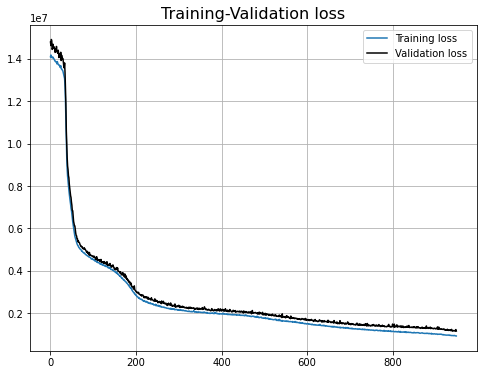

In [ ]:
plt.figure(figsize = (8,6))
plt.plot(train_losses[50:])
plt.plot(val_losses[50:], '-k')
plt.title('Training-Validation loss', fontsize = 16)
plt.grid()
plt.legend(['Training loss','Validation loss'])

# Evalute on the test data

### Scale the test data before evaluating the model

RuntimeError: ignored

In [ ]:
Test_scaler_x = preprocessing.MinMaxScaler(feature_range=feature_range).fit(X_test) # maybe try another for X?
X_Test_scaled = Test_scaler_x.transform(X_test)

predictions = model(torch.tensor(X_Test_scaled).float().to(device)).cpu().detach().numpy()
test_targets = y_test.values

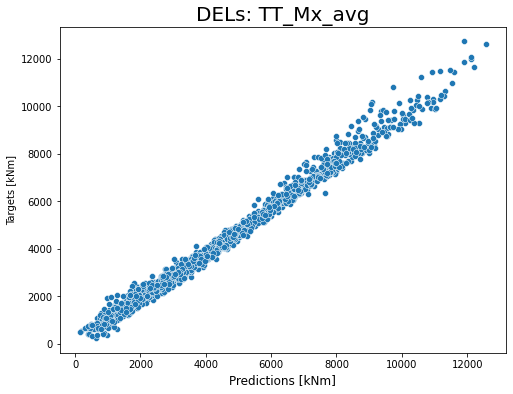

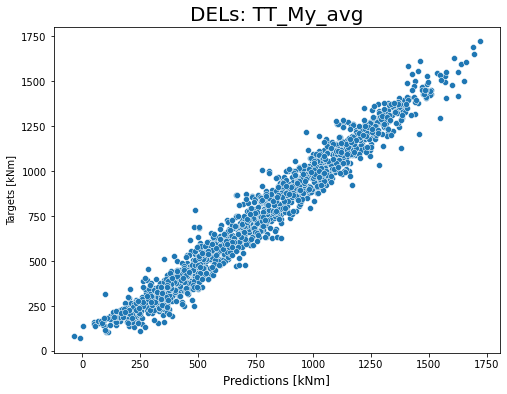

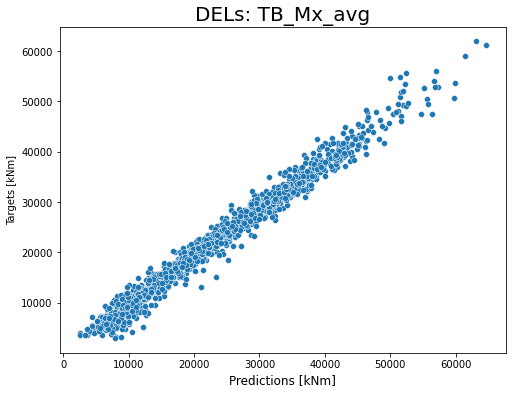

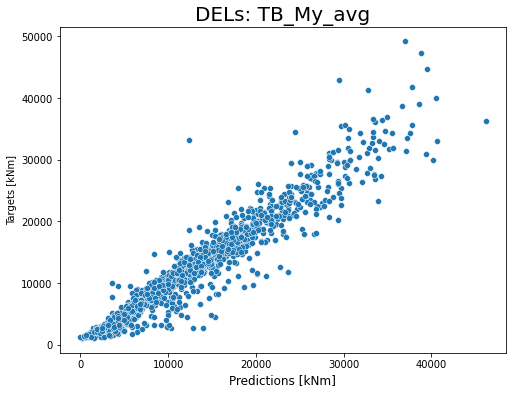

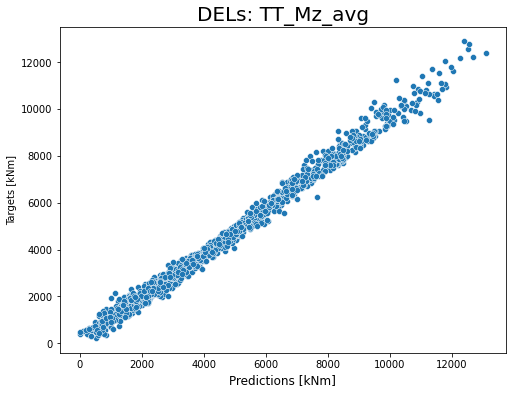

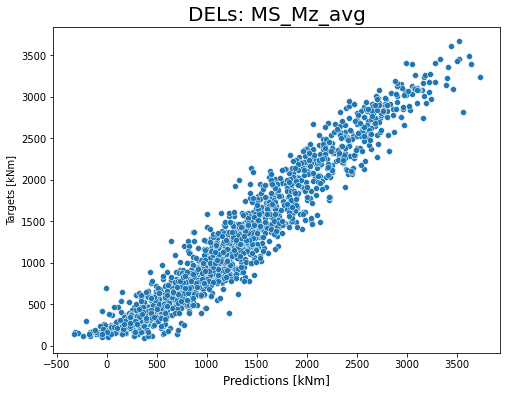

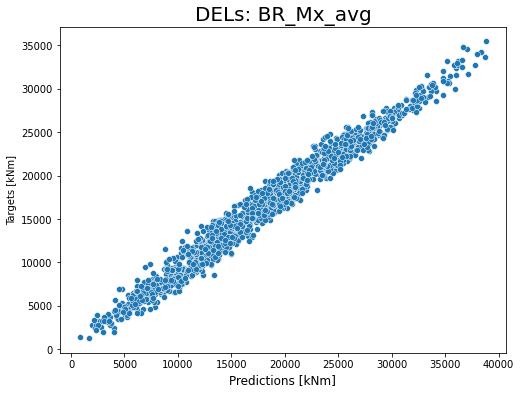

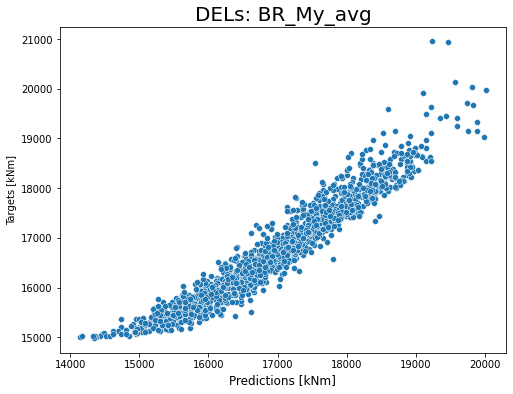

In [ ]:
for idx, ch in enumerate(df.columns.tolist()[8:]):
  # issues with 2 and 7
    plt.figure(idx, figsize = (8,6))
    sns.scatterplot(x = predictions[:,idx], y = test_targets[:,idx])
    plt.title(f'DELs: {ch}', fontsize = 20)
    plt.xlabel('Predictions [kNm]', fontsize = 12)
    plt.ylabel('Targets [kNm]')

In [ ]:
mse_list = []
r2_score_list = []
for i in range(len(df.columns.tolist()[8:])):
    #print(f'MSE {AllTargetData.columns[i]} Channel : \n {mean_squared_error(AllTargetData.values[:,i], Yout[:,i])}')
    mse_list.append(mean_squared_error(test_targets[:,i], predictions[:,i]))
    r2_score_list.append(r2_score(test_targets[:,i], predictions[:,i]))
 

 # Compute the normalized mean square error:
Norm_RMSE = np.sqrt(np.array(mse_list)) / y_test.describe().loc['mean'].values

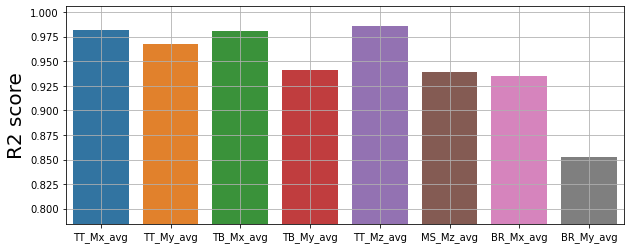

In [ ]:
fig = plt.figure(figsize= (10,4)) 
sns.barplot(x= df.columns.tolist()[8:], y= r2_score_list) 
plt.ylim([min(r2_score_list)*0.92,max(r2_score_list)*1.02])
plt.ylabel('R2 score', fontsize = 20)
plt.grid()

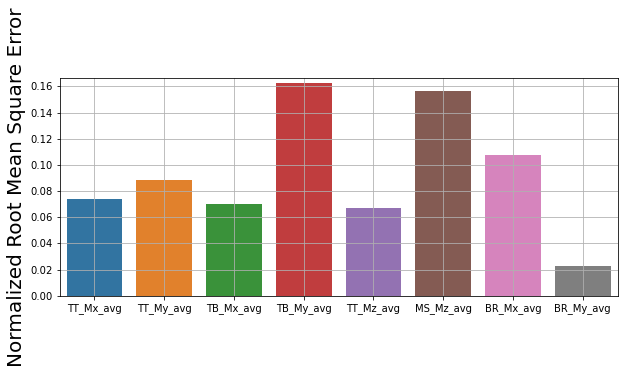

In [ ]:
fig = plt.figure(figsize= (10,4)) 
sns.barplot(x= df.columns.tolist()[8:], y= Norm_RMSE) 
plt.ylim([0,max(Norm_RMSE)*1.02])
plt.ylabel('Normalized Root Mean Square Error', fontsize = 20)
plt.grid()

# ============================================================
# ==========================Section 2 ==========================
# ============================================================
### Compare versus the wind2loads neural net

In [ ]:
error on purpose

SyntaxError: invalid syntax (<ipython-input-21-838280d6483e>, line 1)

In [ ]:
from w2l import neuralnets

In [ ]:
# define the model using the same net architecture, and train for the same number of epochs using the previously batch size as well.
w2l_net = neuralnets.ann(layersizes = [input_size, num_hid_1, num_hid_2, output_channels],
                       params = {'minibatchsize':64, 'nepochs':500}, 
                       output_style = 'None',
                        testratios = [0.7, 0.3, 0.])

In [ ]:
# train using the data from the first split
Outdata = w2l_net.train(X.values,y.values)

Training neural net model:


C:\Users\Bruger\anaconda3\lib\site-packages\w2l\math_utils.py:31: RuntimeWarning: invalid value encountered in true_divide
  rho[0, :M] = (muAB - muA*muB) / \


In [ ]:
w2l_net.params

{'minibatchsize': 64,
 'nepochs': 500,
 'weightinit': [0.01, 0.01, 0.01],
 'regularization': 0.1,
 'learningrate': 0.1,
 'costfunction': 'Lsq',
 'maxiter': 1500,
 'RMSprop': 0.999,
 'Momentum': 0.9,
 'Xscaling': True,
 'Yscaling': True}

In [ ]:
Outdata.keys()

$\color{red}{\text{Why 500 epochs tho}}$

In [ ]:
plt.plot(Outdata['Jhist'][50:])


In [ ]:
Yout = w2l_net.predict(X_test.values) 

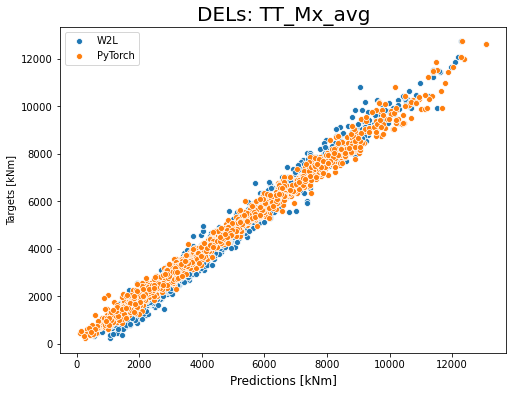

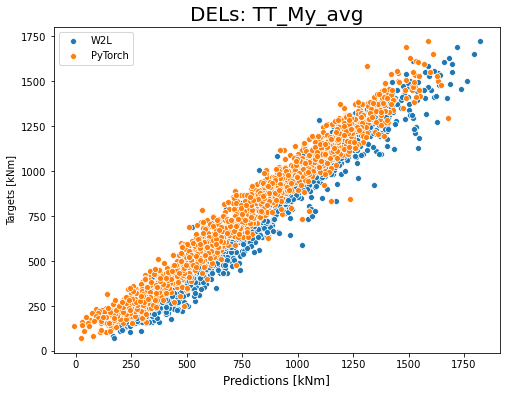

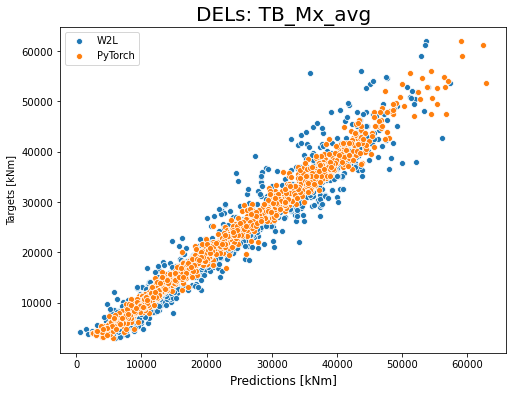

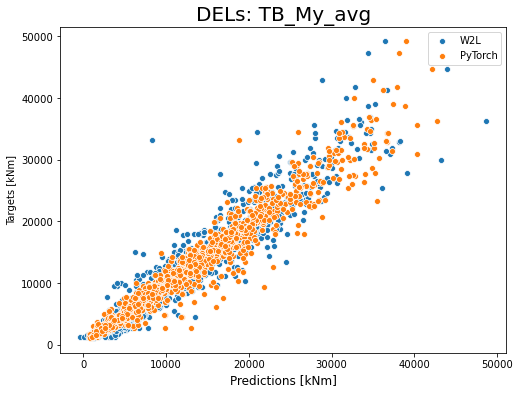

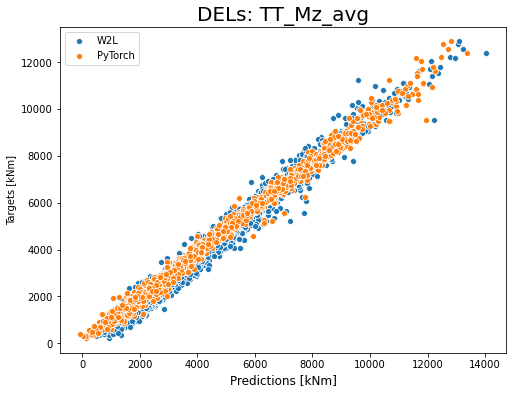

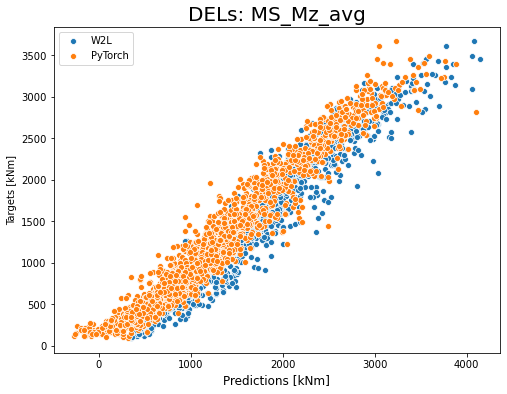

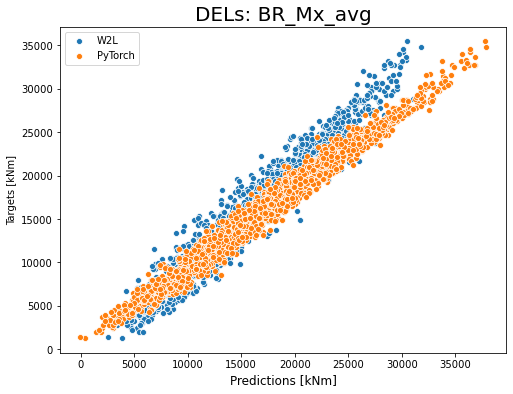

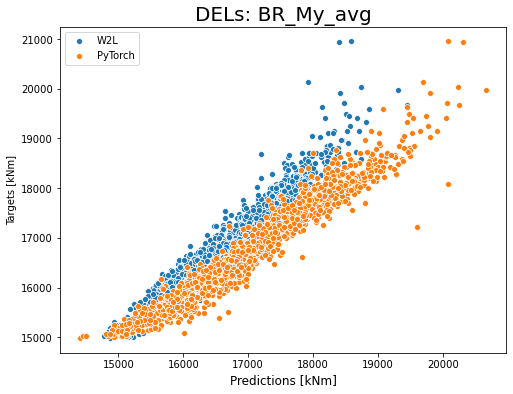

In [ ]:
for idx, ch in enumerate(df.columns.tolist()[8:]):
  # issues with 2 and 7
    plt.figure(idx, figsize = (8,6))
    sns.scatterplot(Yout[:,idx],test_targets[:,idx])
    sns.scatterplot(predictions[:,idx],test_targets[:,idx])
    plt.title(f'DELs: {ch}', fontsize = 20)
    plt.legend(['W2L','PyTorch'])
    plt.xlabel('Predictions [kNm]', fontsize = 12)
    plt.ylabel('Targets [kNm]')

In [ ]:
W2L_mse_list = []
W2L_r2_score_list = []
for i in range(len(df.columns.tolist()[8:])):
    #print(f'MSE {AllTargetData.columns[i]} Channel : \n {mean_squared_error(AllTargetData.values[:,i], Yout[:,i])}')
    W2L_mse_list.append(mean_squared_error(test_targets[:,i], Yout[:,i]))
    W2L_r2_score_list.append(r2_score(test_targets[:,i], Yout[:,i]))
    
W2L_Norm_RMSE = np.sqrt(np.array(W2L_mse_list)) / y_test.describe().loc['mean'].values

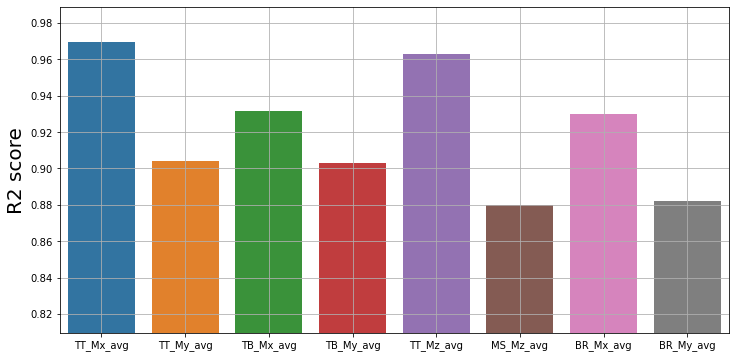

In [ ]:
fig = plt.figure(figsize= (12,6)) 
sns.barplot(x= df.columns.tolist()[8:], y= W2L_r2_score_list) 
plt.ylim([min(W2L_r2_score_list)*0.92,max(W2L_r2_score_list)*1.02])
plt.ylabel('R2 score', fontsize = 20)
plt.grid()

# Compare Wind2Loads net versus PyTorch implementation

In [ ]:
barplot_lst = []
for i,ch in enumerate(df.columns.tolist()[8:]):
    barplot_lst.append(['pytorch',ch,r2_score_list[i]])
for i,ch in enumerate(df.columns.tolist()[8:]):
    barplot_lst.append(['W2L',ch,W2L_r2_score_list[i]])  

In [ ]:
df_comparison = pd.DataFrame(barplot_lst,
                  columns=['Model','channel','r2'])

<Figure size 864x432 with 0 Axes>

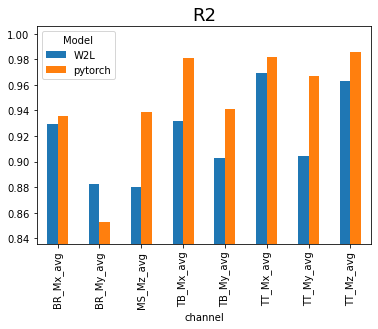

In [ ]:
plt.figure(figsize=(12,6))
df_comparison.pivot("channel", "Model", "r2").plot(kind='bar')
plt.ylim([min(r2_score_list)*0.98,max(r2_score_list)*1.02])
plt.title('R2', fontsize = 18)
plt.show()

In [ ]:
barplot_lst_NMSE = []
for i,ch in enumerate(df.columns.tolist()[8:]):
    barplot_lst_NMSE.append(['pytorch',ch , Norm_RMSE[i]])
for i,ch in enumerate(df.columns.tolist()[8:]):
    barplot_lst_NMSE.append(['W2L', ch, W2L_Norm_RMSE[i]])

In [ ]:
df_NRMSE_comparison = pd.DataFrame(barplot_lst_NMSE,
                  columns=['Model','channel','NRMSE'])



<Figure size 1008x432 with 0 Axes>

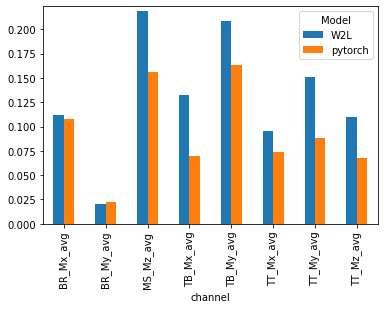

In [ ]:
plt.figure(figsize=(14,6))
df_NRMSE_comparison.pivot("channel", "Model", "NRMSE").plot(kind='bar')
plt.ylim([0,max(W2L_Norm_RMSE)*1.02])
plt.show()